# Goal: Study two-neuron coupling

In [1]:
import numpy as np, matplotlib.pyplot as plt,time, math
from snn.components.neuron_class import Neuron
from snn.components.synapse_class import Synapse
from snn.components.network_class import Network
from snn.functions import *

Normalize integral of PSP instead of the peak

In [2]:
np.random.seed(0)

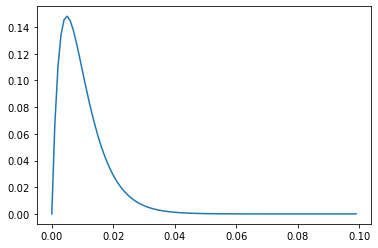

In [3]:
dt = 1e-3
t = dt*np.arange(0, 100)
tau1 = 6e-3
tau2 = 4e-3
h = np.exp(-t/tau1) - np.exp(-t/tau2)
plt.plot(t, h)

In [4]:
integ_h = np.sum(h)*dt
print(integ_h)

0.001993070422616697


Text(0.5, 1.0, 'PSP waveform (integral normalized)')

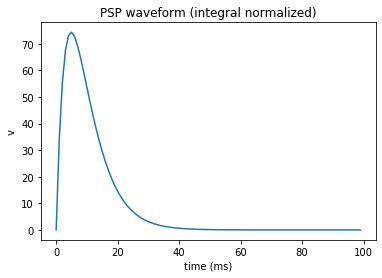

In [5]:
h_norm = h/integ_h
plt.plot(h_norm)
plt.xlabel('time (ms)')
plt.ylabel('v')
plt.title('PSP waveform (integral normalized)')

In [6]:
# v_init=np.random.uniform(0, 1, size=(2,1))
v_init = np.zeros((2, 1))
T = 1000
V_0 = 1.005
v_ext = V_0*np.ones((2, T)) #same frequency of oscillation
v_ext[1,:] = 0 #no input to neuron2
v_ext[0,150:] = 0 #input only for 150ms
adj_mat = np.array([[0, 1], [0, 0]]) #only 1->2

In [7]:
w_val = np.linspace(0, 0.05, 50)

In [8]:
v_post_peak = np.zeros((len(w_val),))

In [9]:
for j in range(len(w_val)):
    w_self = 0
    w_cross = w_val[j]
    net, probe = create_network(2, w_self, w_cross, adj_mat, h_norm, v_init, T)
    for ti in range(T):
        net.update_state(dt, v_ext[:,ti].reshape((-1,1)), probe, ti)
    v_post_peak[j] = np.amax(probe['v'][1,:])

Text(0, 0.5, 'v_post_max (V)')

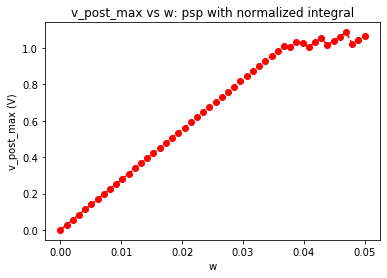

In [10]:
plt.plot(w_val, v_post_peak, 'ro--')
plt.title('v_post_max vs w: psp with normalized integral')
plt.xlabel('w')
plt.ylabel('v_post_max (V)')

(0, 200)

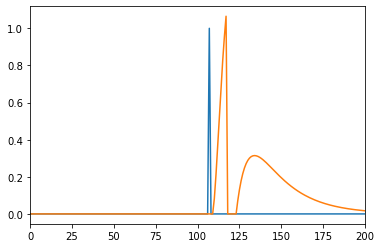

In [11]:
plt.plot(probe['spike'][0,:])
plt.plot(probe['v'][1,:])
plt.xlim(0,200)

settling time using settling of phase instead of settling of frequency

In [12]:
v_init=np.random.uniform(0, 1, size=(2,1))
# v_init = np.zeros((2, 1))
T = 1000
V_0 = 1.005
v_ext = V_0*np.ones((2, T)) #same frequency of oscillation
adj_mat = np.array([[0, 1], [1, 0]]) #only 1->2, 2->1
w_self = 0
w_cross = 0.03
net, probe = create_network(2, w_self, w_cross, adj_mat, h_norm, v_init, T)
for ti in range(T):
    net.update_state(dt, v_ext[:,ti].reshape((-1,1)), probe, ti)


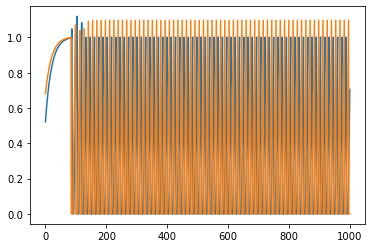

In [13]:
plt.plot(probe['v'][0,:])
plt.plot(probe['v'][1,:])

In [14]:
f, phi = osc_state(probe['spike'], dt)

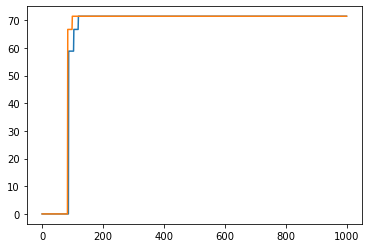

In [15]:
plt.plot(f[0,:])
plt.plot(f[1,:])

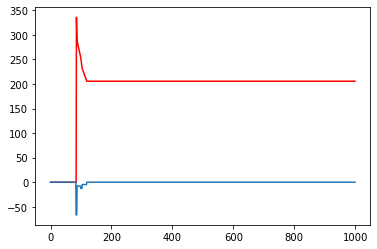

In [16]:
# plt.plot(phi[0,:])
# plt.plot(phi[1,:])
plt.plot((phi[0,:]-phi[1,:])%360, 'r')
plt.plot(f[0,:]-f[1,:])

No difference between using phase and frequency to obtain settling time: since both aren't well defined until the first spike of each neuron

Equivalence between self coupling and refractory period modulation

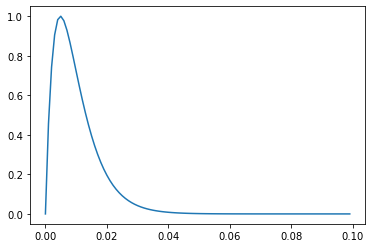

In [17]:
h = np.exp(-t/tau1) - np.exp(-t/tau2)
h = h/np.amax(h)
plt.plot(t,h)

In [43]:
t_ref_all = dt*np.arange(0, 30, 1)
w_self_all = np.linspace(-3, 0, 30)

In [50]:

T = 1000
V_0 = 1.005
v_ext = V_0*np.ones((1, T)) #same frequency of oscillation
f_wself = np.zeros((len(w_self_all),T))
f_tref = np.zeros((len(t_ref_all),T))
for j in range(len(t_ref_all)):
    w_self_1 = w_self_all[j]
    t_ref_2 = t_ref_all[j]
    net = Network('net')
    n1 = Neuron('n1')
    n2 = Neuron('n2', t_ref=t_ref_2)
    net.add_neuron(n1)
    net.add_neuron(n2)

    syn = Synapse('syn_11', n1, n1, h, w=w_self_1)
    net.add_synapse(syn)

    probe = net.initialize(probe=True, T_total = T)

    for ti in range(T):
        net.update_state(dt, v_ext[:,ti].reshape((-1,1)), probe, ti)
    f_all,_ = osc_state(probe['spike'], dt)
    f_wself[j,:] = f_all[0,:]
    f_tref[j,:] = f_all[1,:]

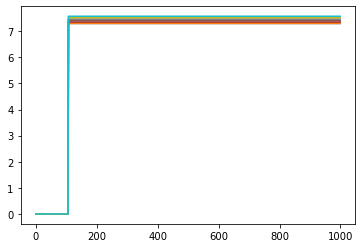

In [51]:
for i in range(10):
    plt.plot(f_wself[i,:])

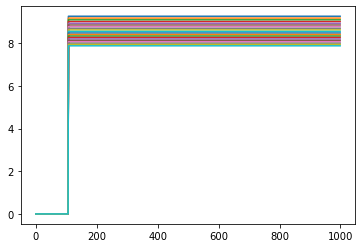

In [52]:
for i in range(20):
    plt.plot(f_tref[i,:])

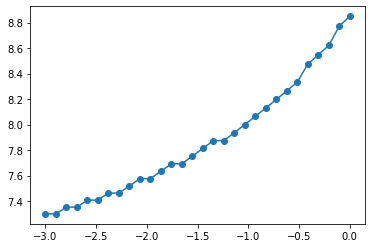

In [56]:
plt.plot(w_self_all[:], f_wself[:,-1], 'o-')

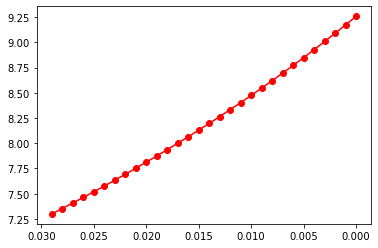

In [62]:
plt.plot(t_ref_all, f_tref[:,-1], 'ro-')
plt.gca().invert_xaxis()

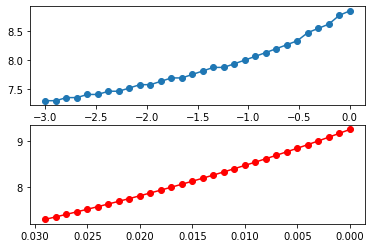

In [70]:
fig, ax = plt.subplots(2)
# ax1 = ax.twinx()

ax[0].plot(w_self_all[:], f_wself[:,-1], 'o-')
ax[1].plot(t_ref_all[::-1], f_tref[::-1,-1], 'ro-')
ax[1].invert_xaxis()

Text(0.5, 0.98, 'Equivalence of w_self and t_ref')

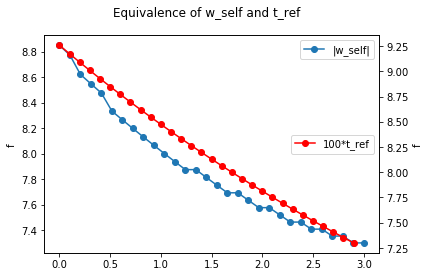

In [83]:
fig, ax = plt.subplots()
ax1 = ax.twinx()

ax.plot(np.abs(w_self_all[:]), f_wself[:,-1], 'o-')
ax1.plot(100*t_ref_all, f_tref[:,-1], 'ro-')
# ax1.invert_xaxis()
ax.legend(['|w_self|'])
ax.set_ylabel('f')
ax1.set_ylabel('f')
ax1.legend(['100*t_ref'], loc='center right')
fig.suptitle('Equivalence of w_self and t_ref')

In [60]:
f_tref[::-1,-1]

array([7.29927007, 7.35294118, 7.40740741, 7.46268657, 7.51879699,
       7.57575758, 7.63358779, 7.69230769, 7.75193798, 7.8125    ,
       7.87401575, 7.93650794, 8.        , 8.06451613, 8.1300813 ,
       8.19672131, 8.26446281, 8.33333333, 8.40336134, 8.47457627,
       8.54700855, 8.62068966, 8.69565217, 8.77192982, 8.84955752,
       8.92857143, 9.00900901, 9.09090909, 9.17431193, 9.25925926])

In [ ]:
t_s_all = np.zeros((20,20))
delphi_all = np.zeros((20,20))
w_converge = np.ones((20,20))
t_ref_all = dt*np.linspace(0, 30, 30)
w_val_cross = np.linspace(0, 3, 30)

In [ ]:
widgets=[progressbar.Bar('#', '[', ']'), ' ', progressbar.Percentage()]
bar = progressbar.ProgressBar(maxval=len(w_val)**2, widgets=widgets).start()
tic = time.time()
for i in range(20):
    for j in range(20):
        bar.update(len(w_val)*i + j+1)
        t_ref = t_ref_all[i]
        w_cross = w_val_cross[j]

        net, probe = create_network(2, 0, w_cross, adj_mat, h, v_init, T)

        for ti in range(T):
            net.update_state(dt, v_ext[:,ti].reshape((-1,1)), probe, ti)
        try:
            f, phi = osc_state(probe['spike'], dt)
        except TypeError:
            print(f"no spikes for w_self={w_self}, w_cross={w_cross} (i={i}, j={j})")
            t_s_all[i,j] = -1
            delphi_all[i,j] = -1
#             break
        if np.abs(f[0,-1]-f[1,-1])<1e-3:
            t_s = settling_time(f[0,:], f[1,:], dt)
            t_s_all[i,j] = t_s
            delphi_all[i,j] = min((phi[0,-1]-phi[1,-1])%360, 360-(phi[0,-1]-phi[1,-1])%360)
        else:
            print(f"no settling for w_self={w_self}, w_cross={w_cross} (i={i}, j={j})")
            t_s_all[i,j] = -1
            delphi_all[i,j] = -1
print(f"total time for {20*20} iterations: {time.time()-tic}s")